In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.manifold import TSNE, LocallyLinearEmbedding
from sklearn.datasets import fetch_openml
import umap.umap_ as umap
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import cv2
import joblib

### 1. Ответы на вопросы

#### 1. Для каких из уже изученных моделей актуально проклятие размерности:

Метод k-ближайших соседей (k-NN):
Этот алгоритм основан на расстояниях между точками. В высоких размерностях расстояния между точками становятся примерно одинаковыми.

Методы кластеризации (например, k-means):
Тоже основан на евклидовых расстояниях. Центры кластеров теряют смысл: в высоких размерностях все точки одинаково далеко от центра.

Деревья решений и ансамбли (Decision Tree, Random Forest, XGBoost):
Чем больше признаков, тем больше вариантов разбиений — растёт риск переобучения. Если есть много нерелевантных признаков, дерево может делать случайные
разбиения по шуму.

Метод опорных векторов (SVM):
В высоких размерностях может быть много пересекающихся классов, особенно при использовании линейного ядра. Сложность ядровой матрицы растёт с числом признаков.

Линейная и логистическая регрессия:
При очень большом количестве признаков возможна мультиколлинеарность (признаки линейно зависимы) переобучение.

#### 2. Разница между PCA и SVD?

PCA (Principal Component Analysis — метод главных компонент) — это метод снижения размерности данных, который позволяет выделить наиболее важные направления (компоненты) в данных, где разброс (вариация) максимально велик.

Цель PCA — найти новые оси (главные компоненты), которые объясняют максимум дисперсии в данных.
Результат — набор новых признаков, линейных комбинаций исходных, упорядоченных по важности.
PCA помогает визуализировать данные, упростить модели, убрать шум и уменьшить размерность.

SVD (Singular Value Decomposition — сингулярное разложение) — это метод факторизации матриц, который представляют любую матрицу A размера m×n в виде произведения трёх матриц:

U — ортогональная матрица m×m,
(столбцы — перпендикулярные векторы длины 1, которые показывают важные направления в строках исходных данных)

Σ — диагональная матрица m×n с неотрицательными сингулярными числами,
(на диагонали — неотрицательные числа, показывающие «силу» или значимость этих направлений)

VT — транспонированная ортогональная матрица n×n.
(строки — перпендикулярные векторы длины 1, которые показывают важные направления в столбцах (признаках) данных)

PCA — это частное применение SVD:
PCA — это метод анализа и снижения размерности, построенный на статистике данных.
SVD — это математический инструмент разложения матриц, который используют для реализации PCA и других задач.

#### 3. Разница между NMF и SVD?

NMF (Non-negative Matrix Factorization) — это разложение матрицы на произведение двух неотрицательных матриц:

A — исходная матрица (размера m×n),
W — матрица признаков (размера m×k),
(Показывает, насколько каждый объект (строка A) состоит из k скрытых тем (компонент))
H — матрица весов (размера k×n),
(Показывает, из каких признаков состоит каждая тема)
Все элементы в W и H ≥ 0.

| Свойство           | SVD                                      | NMF                                                    |
| ------------------ | ---------------------------------------- |--------------------------------------------------------|
| Знаки элементов    | Могут быть положительные и отрицательные | Только неотрицательные (≥ 0)                           |
| Интерпретируемость | Труднее интерпретировать компоненты      | Легко интерпретировать (например, темы, части, «доля») |
| Геометрия          | Ортогональные векторы                    | Нет требования ортогональности                         |
| Назначение         | Математически точное разложение          | Приближённое разложение с ограничением на знак         |
| Применение         | Сжатие, шумоподавление, PCA              | Тематическое моделирование, рекомендации               |


#### 4. Описание структуры алгоритма снижения размерности локально-линейного вложения

Locally Linear Embedding (LLE) — это алгоритм нелинейного снижения размерности, который сохраняет локальные геометрические структуры данных. В отличие от PCA (линейного метода), LLE способен воспроизводить нелинейные зависимости в данных.
Алгоритм состоит из трёх ключевых этапов:
1. Поиск k ближайших соседей (Для каждой точки найти k ближайших точек в исходном пространстве)
2. Вычисление весовых коэффициентов (Найти веса w, чтобы каждая точка аппроксимировалась как линейная комбинация своих соседей)
3. Построение низкоразмерного представления (Найти новые координаты y в пространстве меньшей размерности (d), сохранив веса w)

## 2. Классификация с редкими признаками

#### 1. Загрузите «Набор данных по рекомендациям книг» 

In [2]:
ratings_df = pd.read_csv('data/Ratings.csv')
users_df = pd.read_csv('data/Users.csv')
print('Рейтинги:', ratings_df.head(3), sep='\n')
print('Пользователи:', users_df.head(3), sep='\n')

Рейтинги:
   User-ID        ISBN  Book-Rating
0   276725  034545104X            0
1   276726  0155061224            5
2   276727  0446520802            0
Пользователи:
   User-ID                         Location   Age
0        1               nyc, new york, usa   NaN
1        2        stockton, california, usa  18.0
2        3  moscow, yukon territory, russia   NaN


#### 2. Создайте матрицу взаимодействия пользователя с книгой. Используя разреженные матрицы.

In [3]:
data_df = ratings_df.merge(users_df, how='left', on='User-ID')
data_df.head(8)

User-ID        ISBN  Book-Rating                            Location   Age
0   276725  034545104X            0                   tyler, texas, usa   NaN
1   276726  0155061224            5            seattle, washington, usa   NaN
2   276727  0446520802            0       h, new south wales, australia  16.0
3   276729  052165615X            3                rijeka, n/a, croatia  16.0
4   276729  0521795028            6                rijeka, n/a, croatia  16.0
5   276733  2080674722            0                  paris, n/a, france  37.0
6   276736  3257224281            8         salzburg, salzburg, austria   NaN
7   276737  0600570967            6  sydney, new south wales, australia  14.0

In [4]:
# Удаляем пропуски
filter_df = data_df[data_df['Age'].notna()]

In [5]:
# Матрица взаимодействия (Визуально)
print(filter_df[:5].pivot_table(
    index='User-ID',
    columns='ISBN',
    values='Book-Rating',
    fill_value=0))

ISBN     0446520802  052165615X  0521795028  0600570967  2080674722
User-ID                                                            
276727          0.0         0.0         0.0         0.0         0.0
276729          0.0         3.0         6.0         0.0         0.0
276733          0.0         0.0         0.0         0.0         0.0
276737          0.0         0.0         0.0         6.0         0.0


In [6]:
# Разреженная матрица взаимодействия
# Получаем уникальные ID пользователей и книг
user_ids = filter_df['User-ID'].unique()
book_ids = data_df['ISBN'].unique()

# Создаем словари для маппинга ID в индексы
user_to_idx = {user_id: idx for idx, user_id in enumerate(user_ids)}
book_to_idx = {book_id: idx for idx, book_id in enumerate(book_ids)}

# Подготавливаем данные для разреженной матрицы
rows = filter_df['User-ID'].map(user_to_idx)
cols = filter_df['ISBN'].map(book_to_idx)
data = filter_df['Book-Rating']

# Создаем разреженную матрицу в формате CSR
n_users = len(user_ids)
n_books = len(book_ids)
sparse_matrix = csr_matrix((data, (rows, cols)), shape=(n_users, n_books))

In [7]:
sparse_matrix

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 840288 stored elements and shape (62107, 340556)>

In [8]:
dense_matrix = pd.DataFrame.sparse.from_spmatrix(sparse_matrix)  # Плотная матрица

In [9]:
# Для пользователей
print("Соответствие User-ID → Индекс:")
print({user: idx for idx, user in enumerate(user_ids[:5])})

# Для книг
print("\nСоответствие ISBN → Индекс:")
print({book: idx for idx, book in enumerate(book_ids[:5])})

print("\nВизуальное представление:")
print(dense_matrix.iloc[0:5, 0:11])  # Плотная марица

Соответствие User-ID → Индекс:
{276727: 0, 276729: 1, 276733: 2, 276737: 3, 276745: 4}

Соответствие ISBN → Индекс:
{'034545104X': 0, '0155061224': 1, '0446520802': 2, '052165615X': 3, '0521795028': 4}

Визуальное представление:
   0   1   2   3   4   5   6   7   8   9   10
0   0   0   0   0   0   0   0   0   0   0   0
1   0   0   0   3   6   0   0   0   0   0   0
2   0   0   0   0   0   0   0   0   0   0   0
3   0   0   0   0   0   0   0   6   0   0   0
4   0   0   0   0   0   0   0   0   0  10   0


#### 3. Разделите набор данных на обучающую, действительную и тестовую части.

In [10]:
filter_df.head(5)

User-ID        ISBN  Book-Rating                            Location   Age
2   276727  0446520802            0       h, new south wales, australia  16.0
3   276729  052165615X            3                rijeka, n/a, croatia  16.0
4   276729  0521795028            6                rijeka, n/a, croatia  16.0
5   276733  2080674722            0                  paris, n/a, france  37.0
7   276737  0600570967            6  sydney, new south wales, australia  14.0

In [11]:
X = sparse_matrix
y = filter_df.groupby('User-ID')['Age'].first().values
X.shape[0] == y.shape[0]

True

In [12]:
def search_position_by_id(id_to_find: int, user_ids: np.array):
    pos = np.where(user_ids == id_to_find)[0]
    if pos.size > 0:
        index = pos[0]
        print(f"Позиция пользователя {id_to_find} в массиве: {index}")
    else:
        print("Пользователь не найден")


search_position_by_id(276729, user_ids)

Позиция пользователя 276729 в массиве: 1


In [13]:
sparse_matrix.getrow(1).toarray()[0, :5]

array([0, 0, 0, 3, 6])

In [14]:
print("NaN в y:", np.isnan(y).sum())  # Должно быть 0

NaN в y: 0


In [69]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=21)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=21)

#### 4. Постройте линейные и случайные лесные модели для прогнозирования возраста пользователя на основе взаимодействия пользователя с книгой. Не забудьте выбрать оптимальные параметры.

In [57]:
def print_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"R2: {r2:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")

In [58]:
%%time
ridge = Ridge(random_state=21)
param_distribs = {
    'alpha': [1, 10, 100, 200, 300, 400, 800, 1000],
    'solver': ['auto', 'lsqr', 'sparse_cg']
}
random_search_ridge = RandomizedSearchCV(ridge, param_distributions=param_distribs,
                                         n_iter=10, cv=3, scoring='neg_mean_squared_error',
                                         random_state=21, n_jobs=-1)

random_search_ridge.fit(X_train, y_train)
y_pred = random_search_ridge.predict(X_valid)
print_metrics(y_valid, y_pred)

R2: -0.0140, MSE: 216.9750, RMSE: 14.7301, MAE: 11.6229
CPU times: user 875 ms, sys: 55.8 ms, total: 931 ms
Wall time: 16.8 s


In [59]:
print("Лучшие параметры:", random_search_ridge.best_params_)

Лучшие параметры: {'solver': 'lsqr', 'alpha': 1000}


In [60]:
%%time
forest = RandomForestRegressor(random_state=21)
param_distribs_2 = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True]
}

random_search_forest = RandomizedSearchCV(forest, param_distributions=param_distribs_2,
                                          n_iter=5, cv=3, scoring='neg_mean_squared_error',
                                          random_state=21, n_jobs=-1)

random_search_forest.fit(X_train, y_train)
y_pred = random_search_forest.predict(X_valid)
print_metrics(y_valid, y_pred)

R2: -0.0001, MSE: 213.9944, RMSE: 14.6285, MAE: 11.5340
CPU times: user 1.26 s, sys: 31.8 ms, total: 1.29 s
Wall time: 1min 3s


In [61]:
print("Лучшие параметры:", random_search_forest.best_params_)

Лучшие параметры: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 40, 'bootstrap': True}


#### 5. Используйте PCA и UMAP для уменьшения размерности объектов.

In [43]:
pca = PCA(n_components=100, random_state=21)
X_pca = pca.fit_transform(sparse_matrix)

In [26]:
umap = umap.UMAP(n_components=2, random_state=21)
X_umap = umap.fit_transform(sparse_matrix)

/home/xqwe/miniconda3/envs/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [44]:
print(pd.DataFrame(X_pca).iloc[:5, :5])
print(pd.DataFrame(X_umap)[:5])

          0         1         2         3         4
0 -0.031781 -0.054709 -0.113888 -0.191686 -0.006380
1 -0.031784 -0.054725 -0.113946 -0.191792 -0.006384
2 -0.031781 -0.054709 -0.113888 -0.191686 -0.006380
3 -0.031783 -0.054722 -0.113935 -0.191771 -0.006383
4 -0.031787 -0.054745 -0.114018 -0.191922 -0.006389
          0          1
0  9.265738 -10.897979
1  8.776432 -12.176338
2  9.109412 -10.254536
3  7.694202 -10.936996
4  8.833468 -11.149838


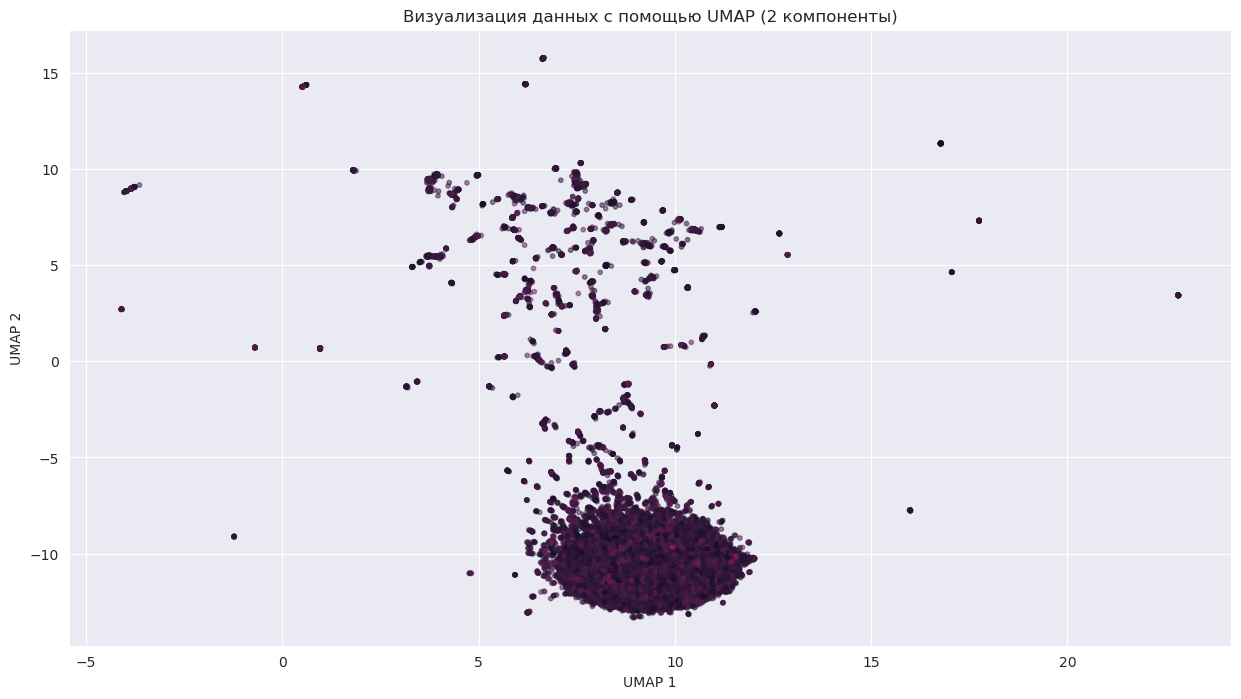

In [28]:
# Визуализация компонент
plt.figure(figsize=(15, 8))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y, s=10, alpha=0.5)
plt.title('Визуализация данных с помощью UMAP (2 компоненты)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.grid(True)
plt.show()

#### 6. Построить линейную модель и модель случайного леса на основе сжатых признаков.

In [62]:
X_train, X_temp, y_train, y_temp = train_test_split(X_pca, y, test_size=0.4, random_state=21)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=21)

In [63]:
%%time
ridge_pca = Ridge(random_state=21)
param_distribs_pca = {
    'alpha': [1, 10, 100, 200, 300, 400, 800, 1000],
    'solver': ['auto', 'lsqr', 'sparse_cg']
}
random_search_ridge_pca = RandomizedSearchCV(ridge_pca, param_distributions=param_distribs_pca,
                                         n_iter=10, cv=3, scoring='neg_mean_squared_error',
                                         random_state=21, n_jobs=-1)

random_search_ridge_pca.fit(X_train, y_train)
y_pred = random_search_ridge_pca.predict(X_valid)
print_metrics(y_valid, y_pred)
print("Лучшие параметры:", random_search_ridge_pca.best_params_)

R2: -0.0044, MSE: 214.9191, RMSE: 14.6601, MAE: 11.5554
Лучшие параметры: {'solver': 'lsqr', 'alpha': 1000}
CPU times: user 446 ms, sys: 39.3 ms, total: 486 ms
Wall time: 2.68 s


In [65]:
%%time
forest_pca = RandomForestRegressor(random_state=21)
param_distribs_2_pca = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True]
}

random_search_forest_pca = RandomizedSearchCV(forest_pca, param_distributions=param_distribs_2_pca,
                                          n_iter=5, cv=3, scoring='neg_mean_squared_error',
                                          random_state=21, n_jobs=-1, verbose=2)

random_search_forest_pca.fit(X_train, y_train)
y_pred = random_search_forest_pca.predict(X_valid)
print_metrics(y_valid, y_pred)
print("Лучшие параметры:", random_search_forest_pca.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
R2: -0.0022, MSE: 214.4439, RMSE: 14.6439, MAE: 11.5488
Лучшие параметры: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': True}
CPU times: user 36.4 s, sys: 594 ms, total: 37 s
Wall time: 3min 56s


#### 7. Сравните время и качество подгонки для моделей

| Model           | R²      | MSE      | RMSE    | MAE     | Time (Wall)    |
| --------------- | ------- | -------- | ------- | ------- | -------------- |
| **Ridge**       | -0.0140 | 216.9750 | 14.7301 | 11.6229 | 16.8 s         |
| **Random Forest** | -0.0001 | 213.9944 | 14.6285 | 11.5340 | **1 min 3 s**  |
| **Ridge + PCA** | -0.0044 | 214.9191 | 14.6601 | 11.5554 | 2.68 s         |
| **Random Forest + PCA**      | -0.0022 | 214.4439 | 14.6439 | 11.5488 | **3 min 56 s** |


## 3. Визуализации (MNIST)

#### 1. Загрузите набор данных MNIST

In [3]:
mnist = fetch_openml('mnist_784', version=1) # Уже векторизовано
X = mnist['data'].values
y = mnist['target'].values

#### 2. Представьте каждое цифровое изображение в виде вектора.

In [4]:
digit_image = X[0].reshape(28, 28)  # Восстанавливаем матрицу
print("Форма до преобразования:", digit_image.shape)  # (28, 28)
# Преобразуем обратно в вектор (разворачиваем)
digit_vector = digit_image.flatten()
print("Форма после преобразования:", digit_vector.shape)  # (784,)

Форма до преобразования: (28, 28)
Форма после преобразования: (784,)


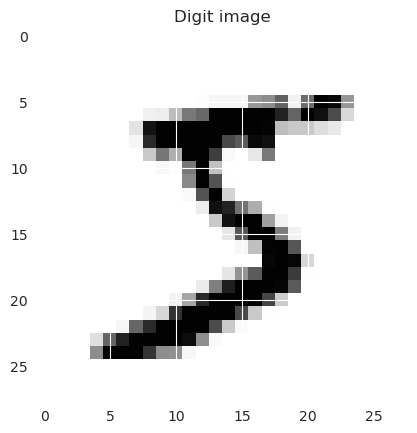

In [5]:
plt.title('Digit image')
plt.imshow(digit_image, cmap='Greys')
plt.show()

#### 3. Преобразуйте векторы до 2 измерений с помощью PCA, SVD, Randomized-SVD, TSNE, UMAP и LLE.

| Метод             | Тип                | Краткое описание                                              | Преимущества                                     | Недостатки                                          | Особенности применения                      |
|-------------------|--------------------|---------------------------------------------------------------|-------------------------------------------------|----------------------------------------------------|---------------------------------------------|
| **PCA**           | Линейный           | Метод главных компонент. Проецирует данные на подпространство с максимальной дисперсией. | Быстрый, прост в реализации, интерпретируемый.  | Не улавливает сложные нелинейные зависимости.      | Хорош для предварительной обработки, уменьшения размерности перед другими методами. |
| **Truncated SVD**  | Линейный           | Приближённое сингулярное разложение для разреженных и больших матриц.                     | Быстрее PCA для больших и разреженных данных.  | Аналогичные ограничения как у PCA.                   | Часто используется для обработки разреженных данных. |
| **Randomized SVD** | Линейный           | Быстрый алгоритм для вычисления SVD на больших данных с использованием случайных проекций. | Быстрее классического SVD, масштабируемый.      | Может иметь небольшую погрешность в аппроксимации.  | Используется по умолчанию в sklearn TruncatedSVD. |
| **t-SNE**          | Нелинейный         | Сохраняет локальные соседства, проецируя данные в низкоразмерное пространство.            | Хорошо разделяет классы, наглядная визуализация.| Медленный, чувствителен к параметрам (perplexity).  | Лучше использовать после уменьшения размерности (например, PCA). |
| **UMAP**           | Нелинейный         | Сохраняет топологическую структуру данных с помощью графовых подходов.                     | Быстрее и масштабируемее t-SNE, хорошо отделяет классы.| Параметры требуют настройки, иногда чувствителен к шуму.| Современный метод, хорошо работает на больших выборках. |
| **LLE**            | Нелинейный         | Восстанавливает локальную линейную структуру данных в низкоразмерном пространстве.        | Хорошо сохраняет геометрию данных.               | Неустойчив к шуму, выбор числа соседей влияет сильно.| Требует корректного выбора параметров, чувствителен к выбросам. |

In [7]:
def scatter_2d(X, y, title):
    plt.figure(figsize=(15, 8))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, s=10, palette='tab10', alpha=0.5)
    plt.title(f"{title} на MNIST (2D)")
    plt.xlabel("Компонента 1")
    plt.ylabel("Компонента 2")
    plt.legend(title='Цифры')
    plt.show()

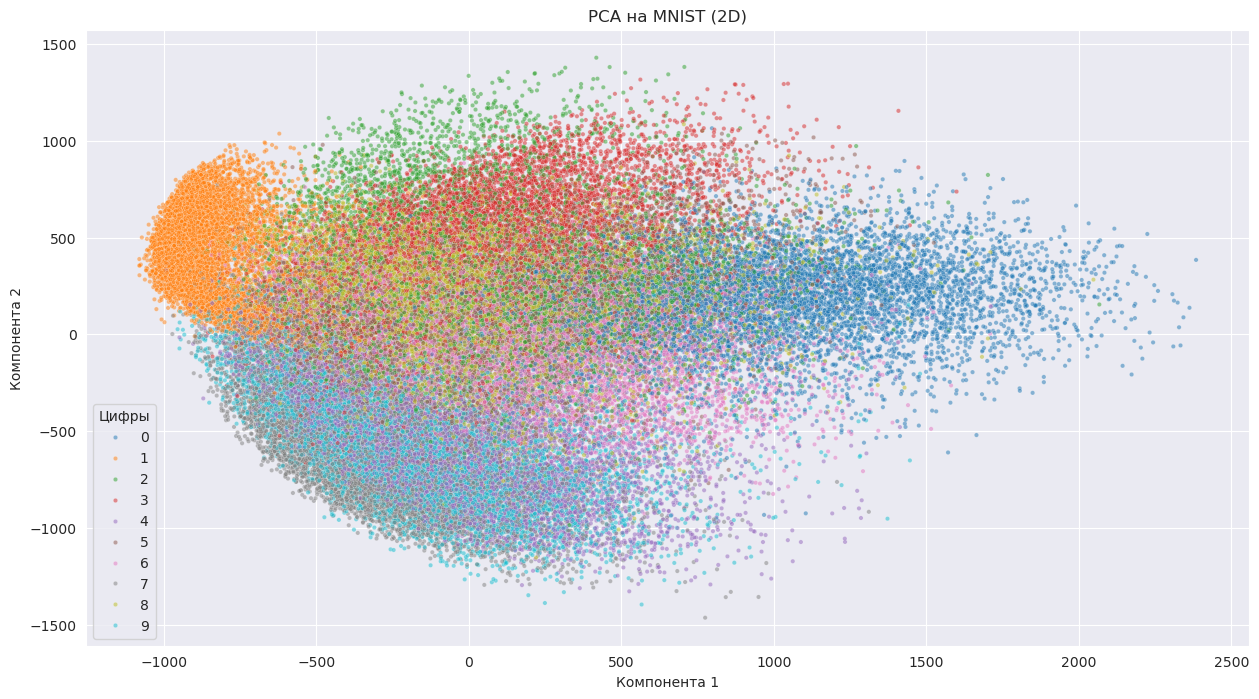

In [8]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
scatter_2d(X_pca, y, 'PCA')

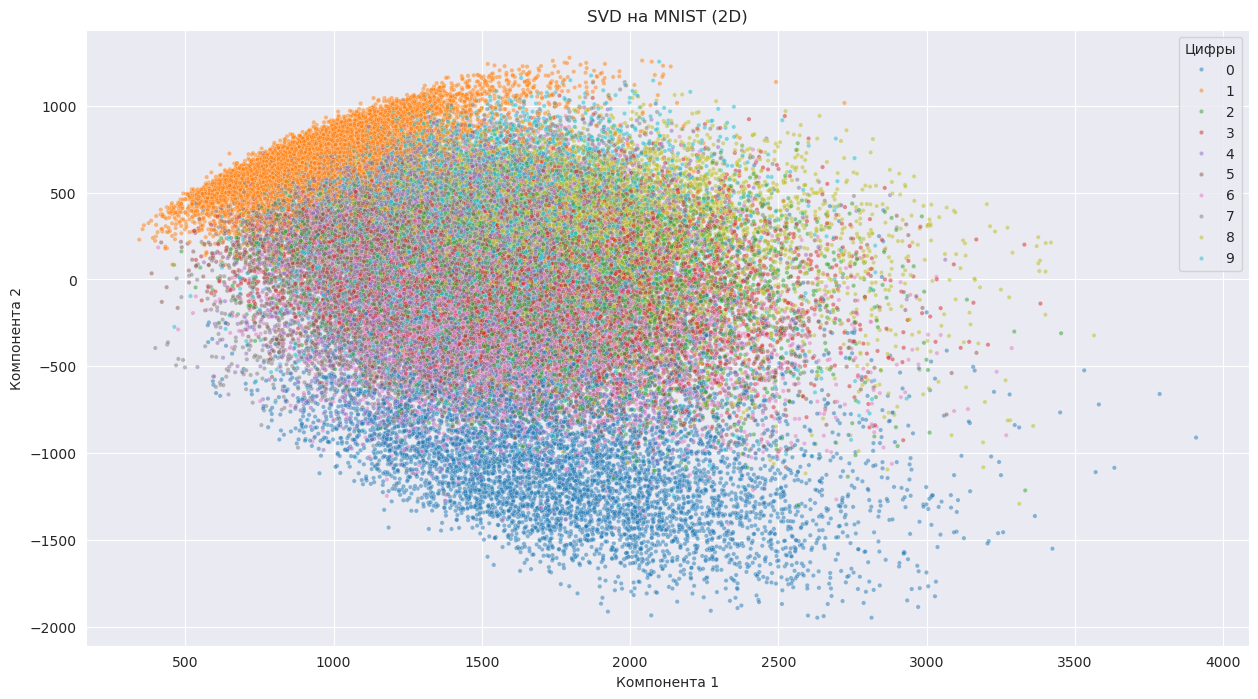

In [9]:
svd = TruncatedSVD(n_components=2)
X_svd = svd.fit_transform(X)
scatter_2d(X_svd, y, 'SVD')

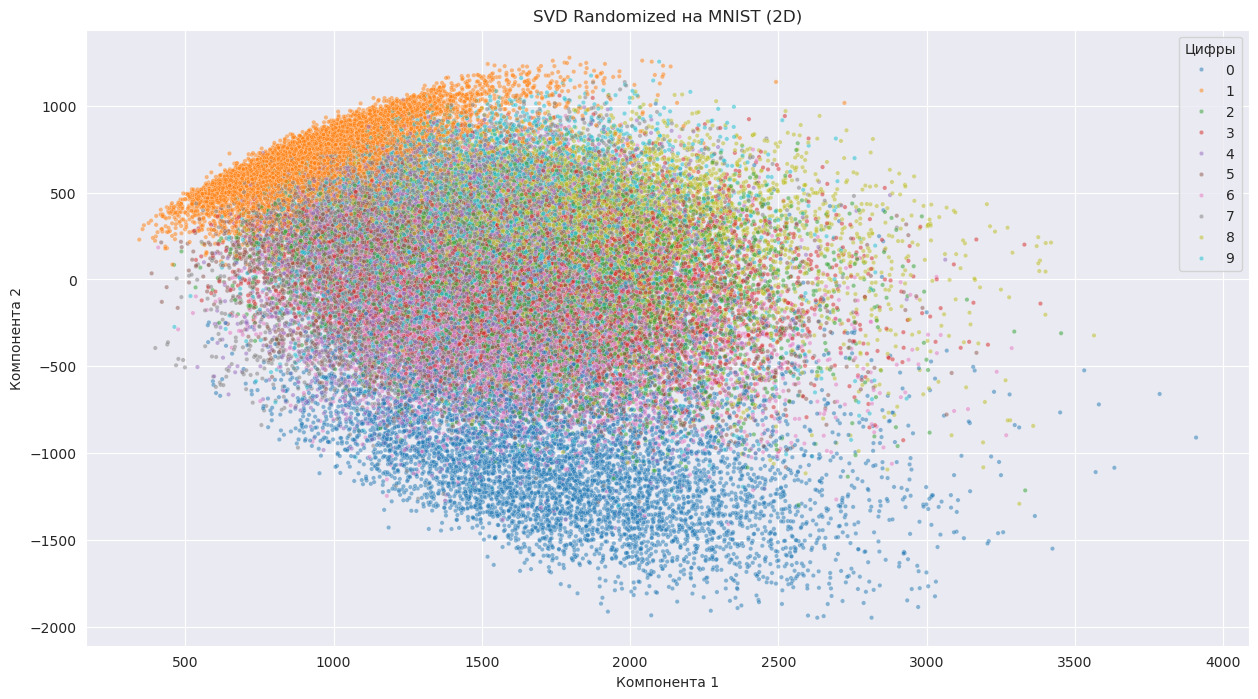

In [10]:
svd_random = TruncatedSVD(n_components=2, algorithm='randomized')
X_svd_random = svd_random.fit_transform(X)
scatter_2d(X_svd_random, y, 'SVD Randomized')

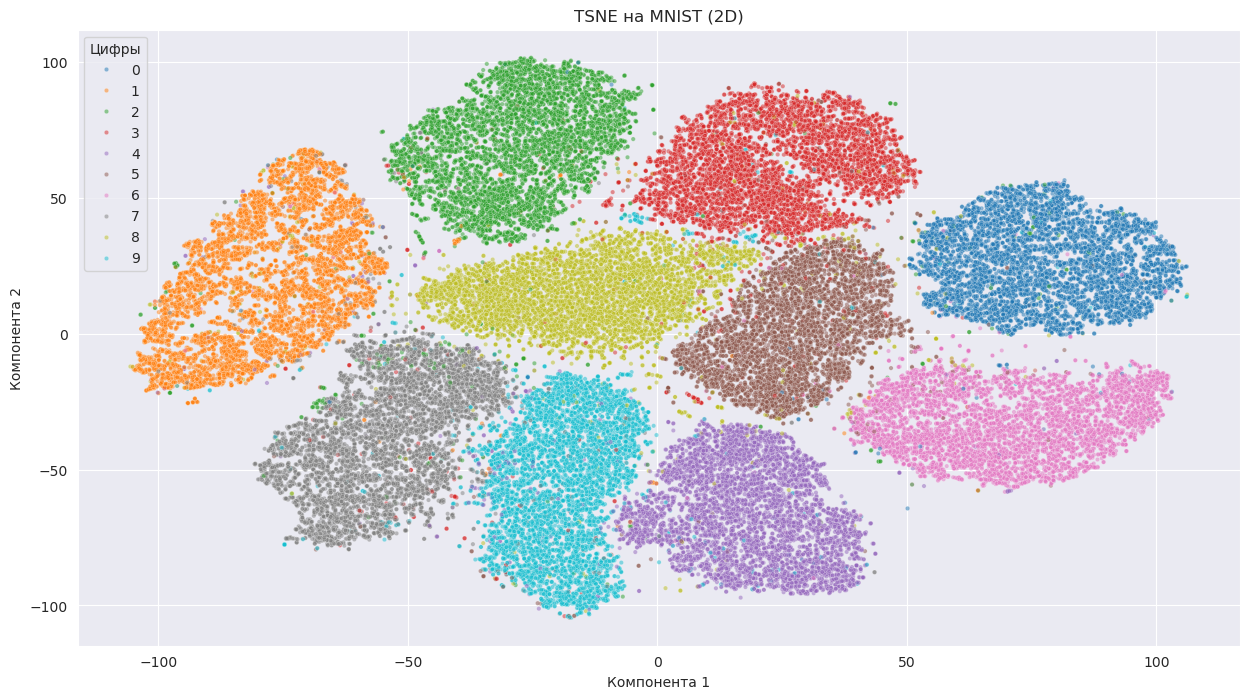

In [15]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
scatter_2d(X_tsne, y, 'TSNE')

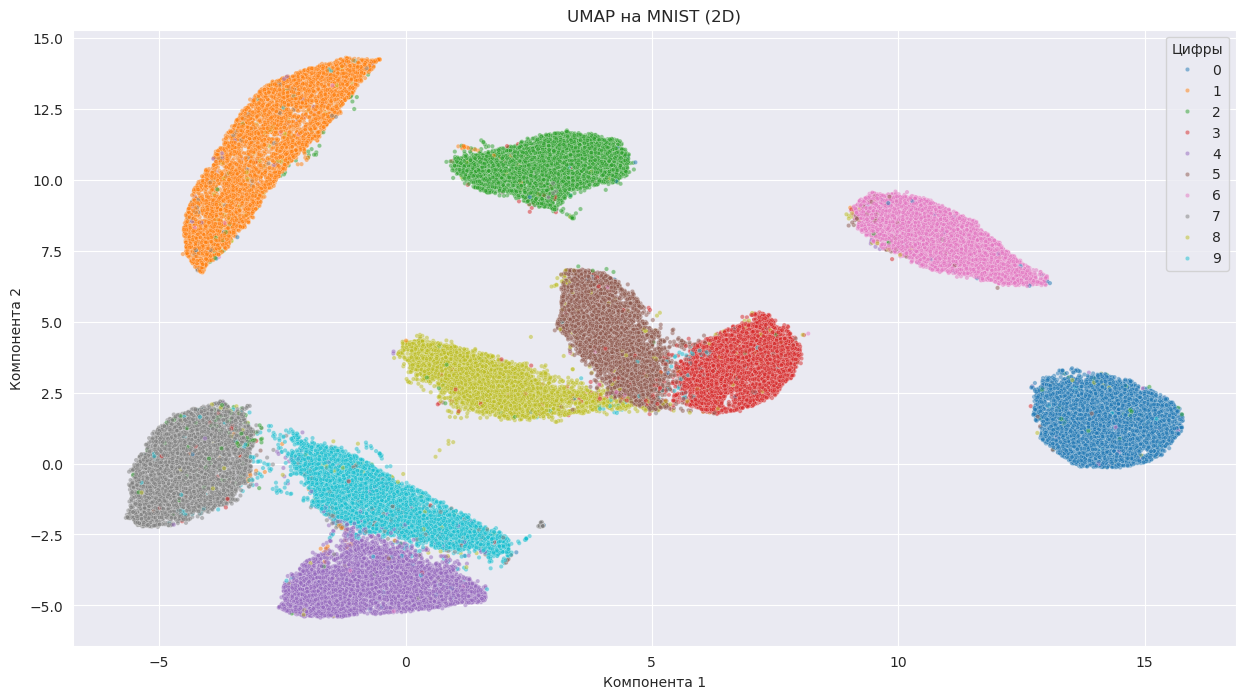

In [11]:
umap = umap.UMAP(n_components=2)
X_umap = umap.fit_transform(X)
scatter_2d(X_umap, y, 'UMAP')

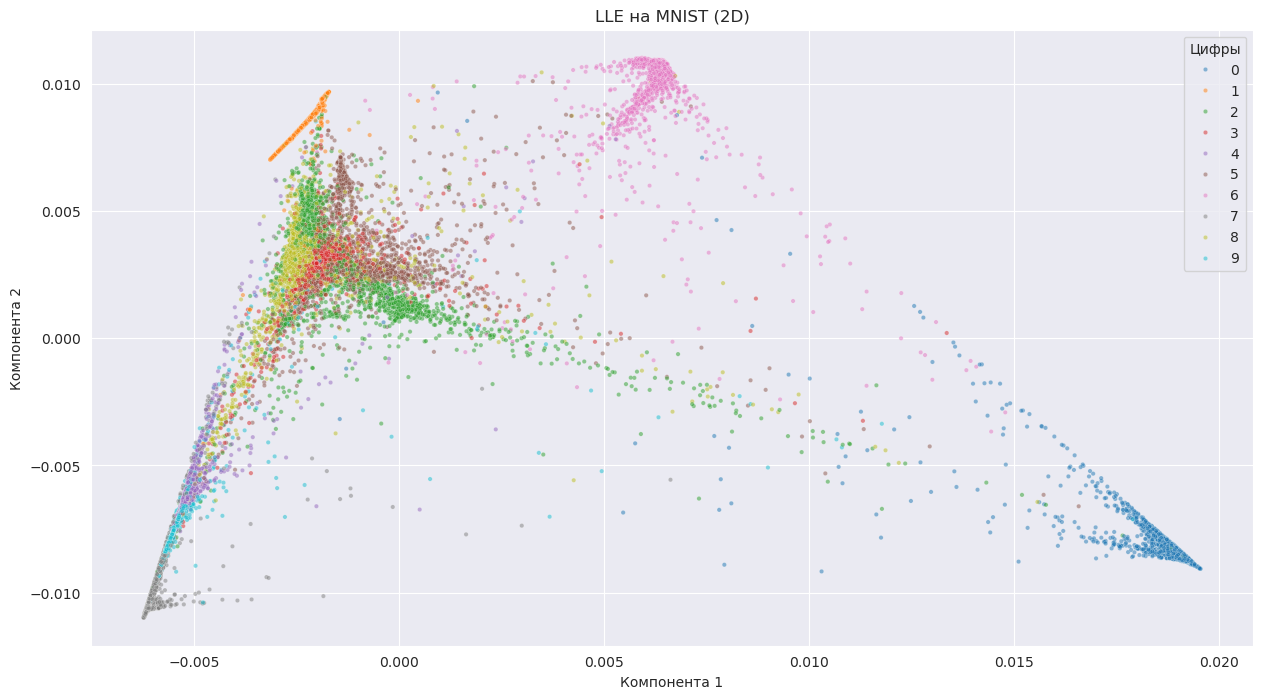

In [19]:
lle = LocallyLinearEmbedding(n_components=2)
X_lle = lle.fit_transform(X[:20000]) # Очень долго (снижение размера выборки)
scatter_2d(X_lle, y[:20000], 'LLE')

#### *Сохраните одну из моделей из части "Визуализации" задания. Ваш коллега загрузит ее и использует для сжатия одной из рукописных цифр. Сжатый вектор должен иметь те же значения.

In [190]:
joblib.dump(svd, 'models/svd_model.joblib')

['models/svd_model.joblib']

#### 4. Предложите метрики и сравните модели на основе того, насколько хорошо они разделяют классы цифр.

| Метрика                 | Описание                                                                 | Лучше, если...        | Комментарий                                                  |
|-------------------------|--------------------------------------------------------------------------|------------------------|---------------------------------------------------------------|
| **Silhouette Score**    | Оценивает, насколько близко точки к своему кластеру и далеко от других   | Ближе к **1**          | Хорошее разделение — кластеры плотные и разнесённые          |
| **Calinski-Harabasz**   | Отношение межкластерной дисперсии к внутрикластерной                     | Чем **выше**, тем лучше | Высокие значения означают плотные и хорошо разделённые кластеры |
| **Davies-Bouldin Index**| Среднее перекрытие кластеров, основанное на расстоянии и разбросе        | Чем **ниже**, тем лучше | Меньшие значения = меньшая схожесть между кластерами         |
| **KNN Accuracy**        | Точность классификации методом k-ближайших соседей в 2D-пространстве      | Чем **выше**, тем лучше | Прямая оценка пригодности 2D-встраивания для классификации   |


In [17]:
def evaluate_embedding(X_embedded, labels, name="Метод"):
    sil = silhouette_score(X_embedded, labels)
    cal = calinski_harabasz_score(X_embedded, labels)
    db = davies_bouldin_score(X_embedded, labels)

    # Простая KNN-классификация по 2D координатам
    knn = KNeighborsClassifier(n_neighbors=5)
    acc = cross_val_score(knn, X_embedded, labels, cv=5).mean()
    
    return {
        "Метод": name,
        "Silhouette": sil,
        "Calinski-Harabasz": cal,
        "Davies-Bouldin": db,
        "KNN Accuracy": acc
    }

In [22]:
results = []
results.append(evaluate_embedding(X_pca, y, "PCA"))
results.append(evaluate_embedding(X_svd, y, "SVD"))
results.append(evaluate_embedding(X_umap, y, "UMAP"))
results.append(evaluate_embedding(X_tsne, y, "t-SNE"))
results.append(evaluate_embedding(X_lle, y[:20000], "LLE")) # Затратное снижение размерности (меньше выборка, не для сравнения!)

In [23]:
print(pd.DataFrame(results))

   Метод  Silhouette  Calinski-Harabasz  Davies-Bouldin  KNN Accuracy
0    PCA    0.022645       12388.704805        5.912752      0.415914
1    SVD   -0.029436        6291.513747       10.653484      0.301386
2   UMAP    0.524399      101606.276799        0.774051      0.968371
3  t-SNE    0.376638       51418.690135        0.926110      0.972257
4    LLE    0.308558       34819.817603        2.631774      0.830050


## 4. Сжатие изображений с использованием SVD

#### 1. Выберите 3 случайных изображения в оттенках серого и загрузите их в матрицу с помощью Python.

In [129]:
mnist = fetch_openml('mnist_784', version=1) # Уже векторизовано
X = mnist['data'].values
y = mnist['target'].values

In [130]:
np.random.seed(21)
indices = np.random.choice(len(X), size=3, replace=False)

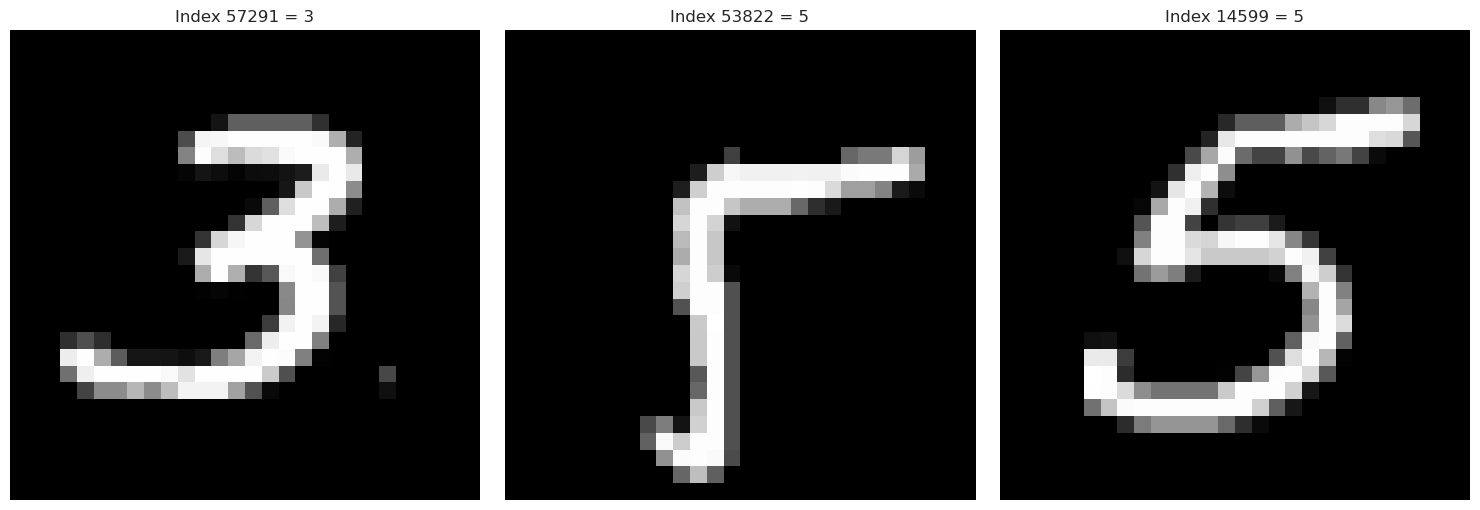

In [131]:
plt.figure(figsize=(15, 5))

for i, idx in enumerate(indices):
    digit = X[idx].reshape(28, 28)
    plt.subplot(1, len(indices), i + 1)
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.title(f'Index {idx} = {y[idx]}')
    
plt.tight_layout()
plt.show()

#### 2. Разложите матрицу с помощью SVD.

In [92]:
img = X[indices[0]].reshape(28, 28)
U, S, VT = np.linalg.svd(img, full_matrices=False)

#### 3. Изменяйте ранг, вычисляйте низкоранговое приближение исходной матрицы и стройте восстановленное изображение. Используйте до 10 различных рангов. Как выглядит спектр сингулярных значений и сколько мод необходимо для хорошей реконструкции изображения?

In [96]:
# Функция восстановления изображения с рангом k
def reconstruct_img(U, S, VT, k):
    S_k = np.diag(S[:k])
    return U[:, :k] @ S_k @ VT[:k, :]

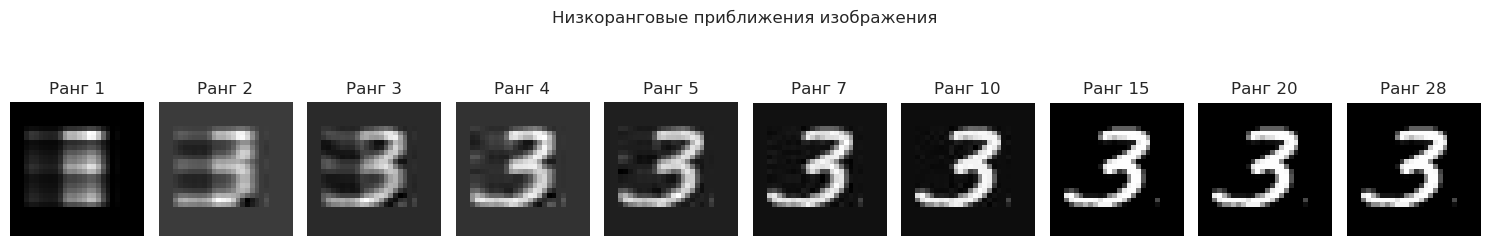

In [97]:
ranks = [1, 2, 3, 4, 5, 7, 10, 15, 20, 28]

# Визуализация восстановленных изображений
plt.figure(figsize=(15, 3))
for i, k in enumerate(ranks):
    img_approx = reconstruct_img(U, S, VT, k)
    plt.subplot(1, len(ranks), i+1)
    plt.imshow(img_approx, cmap='gray')
    plt.title(f'Ранг {k}')
    plt.axis('off')
plt.suptitle('Низкоранговые приближения изображения')
plt.tight_layout()
plt.show()

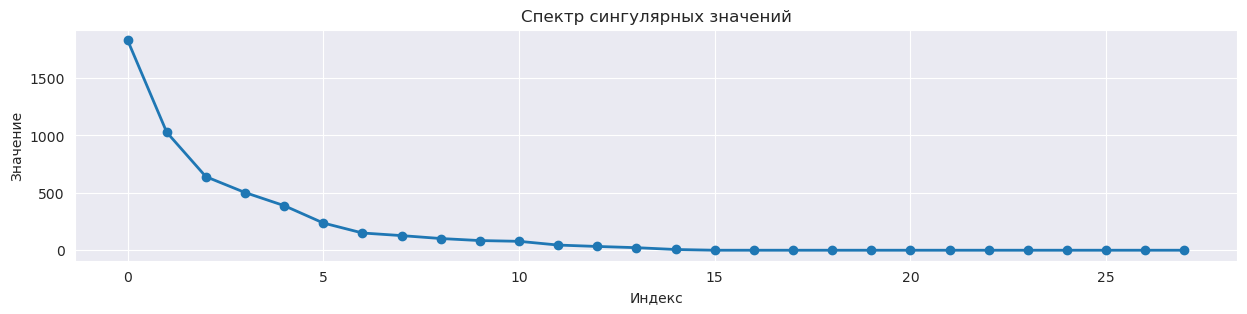

In [98]:
plt.figure(figsize=(15, 3))
plt.plot(S, 'o-', linewidth=2)
plt.title('Спектр сингулярных значений')
plt.xlabel('Индекс')
plt.ylabel('Значение')
plt.grid(True)
plt.show()

#### 4. Постройте график распределения объясненной дисперсии в зависимости от ранга. Объясните, что такое «объясненная дисперсия».

Объяснённая дисперсия — это показатель качества снижения размерности, показывающий, какую долю общей вариации (информации) исходных данных сохраняют выбранные компоненты после преобразования. Она отражает, насколько хорошо новое, уменьшенное по размерности представление описывает исходные данные.

- Позволяет определить минимальное количество компонент, достаточное для представления данных с приемлемой точностью 
- Используется в методах снижения размерности, таких как PCA, SVD, чтобы выбрать оптимальный баланс между сокращением размерности и потерей информации.
- Высокое значение объяснённой дисперсии указывает на то, что уменьшенное представление сохраняет основную структуру данных, снижая шум и избыточность.


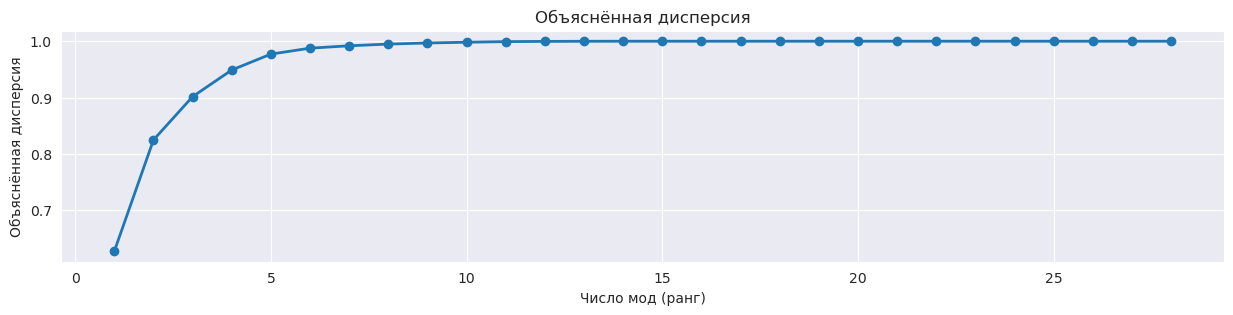

In [128]:
img = X[indices[0]].reshape(28, 28)
U, S, VT = np.linalg.svd(img, full_matrices=False)
explained_variance = np.cumsum(S**2) / np.sum(S**2)
plt.figure(figsize=(15, 3))
plt.plot(range(1, len(S) + 1), explained_variance, 'o-', linewidth=2)
plt.title('Объяснённая дисперсия')
plt.xlabel('Число мод (ранг)')
plt.ylabel('Объяснённая дисперсия')
plt.grid(True)
plt.show()

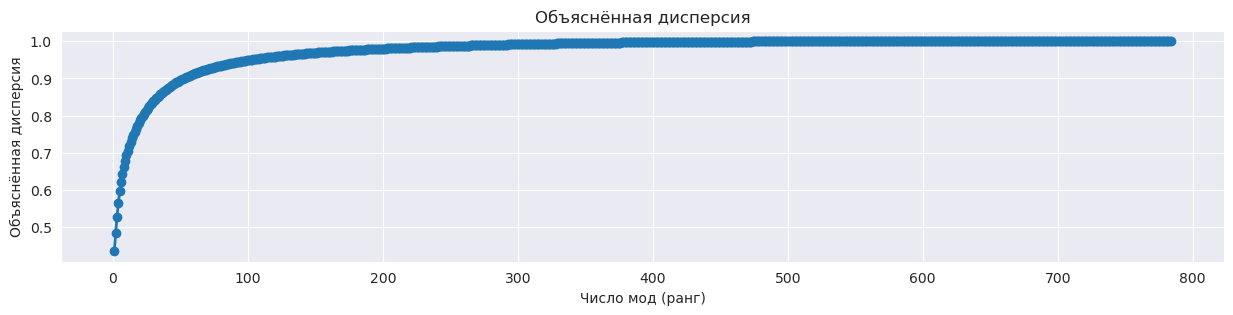

In [123]:
# Для всего MNIST (784)
U, S, VT = np.linalg.svd(X, full_matrices=False)
explained_variance = np.cumsum(S**2) / np.sum(S**2)
plt.figure(figsize=(15, 3))
plt.plot(range(1, len(S) + 1), explained_variance, 'o-', linewidth=2)
plt.title('Объяснённая дисперсия')
plt.xlabel('Число мод (ранг)')
plt.ylabel('Объяснённая дисперсия')
plt.grid(True)
plt.show()

## 5. Детектирование фона с помощью SVD

#### 1. Загрузите «Video_008.avi»

In [148]:
video_path = 'data/Video_008.avi'

#### 2. Представьте видео в виде матрицы и разложите его с помощью SVD.

In [154]:
cap = cv2.VideoCapture(video_path)
frames = []
while True:
    ret, frame = cap.read()
    if not ret:
        break
    # Если нужно, преобразуем в оттенки серого
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frames.append(gray_frame)

cap.release()
# список с кадрами видео в оттенках серого
print(f"Загружено {len(frames)} кадров")

Загружено 792 кадров


In [162]:
frames = np.array(frames)
num_frames, height, width = frames.shape
# Представляем каждый кадр как вектор
M = frames.reshape(num_frames, height * width) 
print(M.shape)

(792, 76800)


In [163]:
# Применяем SVD
U, S, VT = np.linalg.svd(M, full_matrices=False)

print(f'U shape: {U.shape}')
print(f'S shape: {S.shape}')
print(f'VT shape: {VT.shape}')

U shape: (792, 792)
S shape: (792,)
VT shape: (792, 76800)


#### 3. Восстановите первый кадр, используя низкоранговое приближение. Какой ранг следует использовать для получения фона?

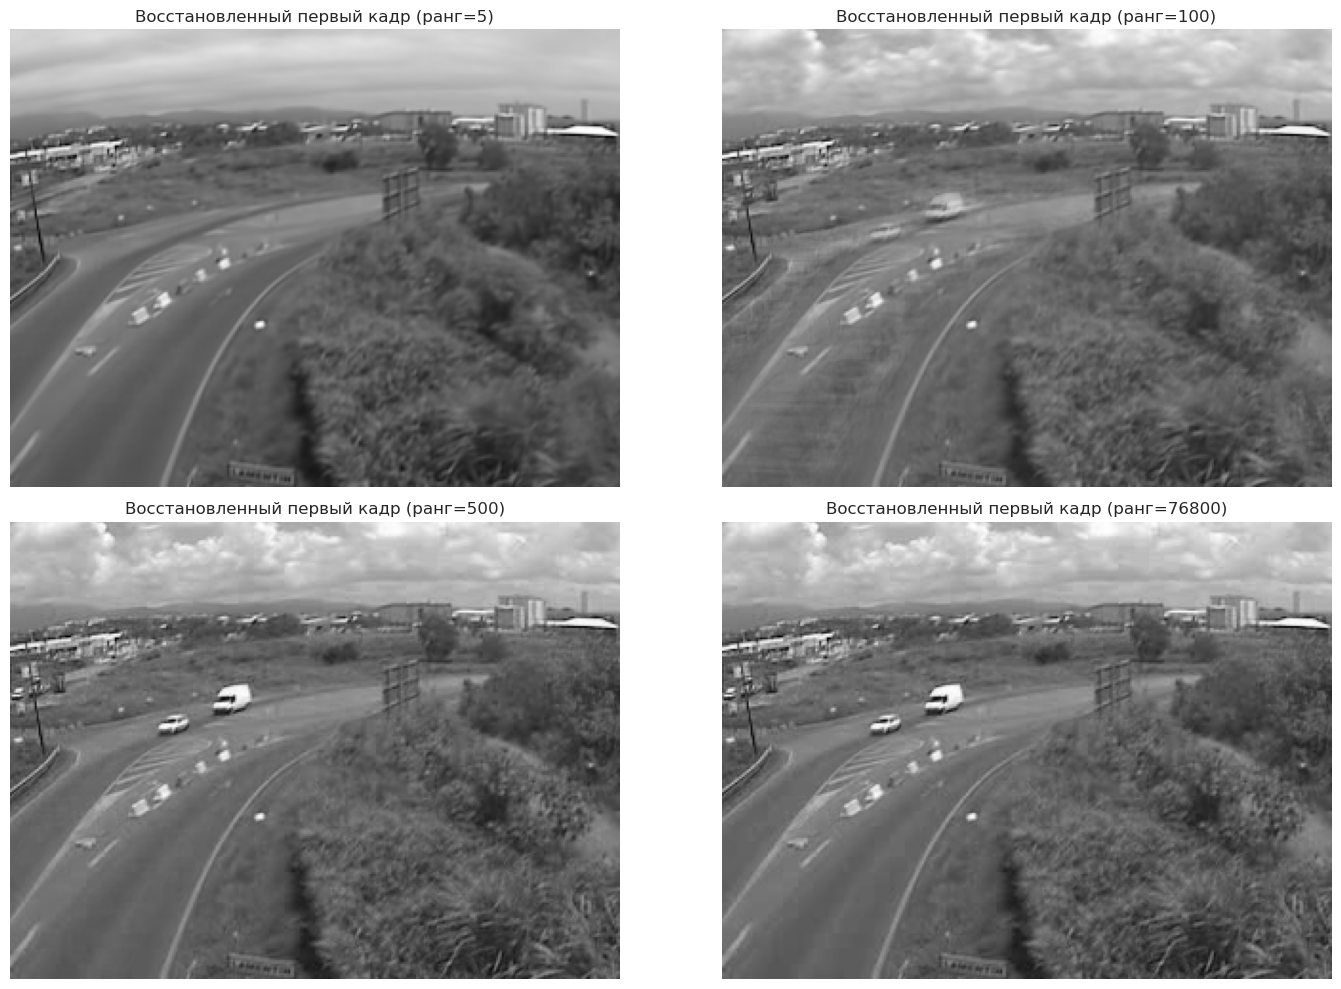

In [184]:
def reconstruct_frame(U, S, VT, frame_idx, k):
    S_k = np.diag(S[:k])
    M_k = U[:, :k] @ S_k @ VT[:k, :]
    frame_recon = M_k[frame_idx].reshape(height, width) # Обратное преобразование
    return frame_recon

# Пример для первого кадра с рангом k
reconstruct_ranks = [5, 100, 500, 76800] 

plt.figure(figsize=(15, 10))
for i, rank in enumerate(reconstruct_ranks):
    frame_approx = reconstruct_frame(U, S, VT, frame_idx=0, k=rank)
    plt.subplot(2, 2, i+1)
    plt.imshow(frame_approx, cmap='gray')
    plt.title(f'Восстановленный первый кадр (ранг={rank})')
    plt.axis('off')

plt.tight_layout()
plt.show()

Для выделения фона в видео через низкоранговое приближение с помощью SVD обычно используют малый ранг, потому что фон — это обычно статичная или медленно меняющаяся часть (Часто достаточно ранга от 1 до 10)

## 6. Бонусная часть

#### 1. Используя набор данных распознавания выражений лиц, подберите модель снижения размерности для сжатия лиц. Используя полученные представления, попробуйте превратить грустное лицо в улыбающееся и наоборот.

In [14]:
# Загружаем изображения
def load_images(path, size=(48, 48)):
    images = []
    for filename in os.listdir(path):
        image = cv2.imread(os.path.join(path, filename), cv2.IMREAD_GRAYSCALE)
        if image is not None:
            image = cv2.resize(image, size)
            images.append(image)
    return np.array(images)
            
X_sad = load_images('data/sad', size=(48, 48))
X_happy = load_images('data/happy', size=(48, 48))

print(f'Sad images: {X_sad.shape}')
print(f'Happy images: {X_happy.shape}')

Sad images: (4938, 48, 48)
Happy images: (7164, 48, 48)


In [71]:
X = np.vstack([X_sad, X_happy]) / 255 # нормализация [0,1]
y = np.array([0]*len(X_sad) + [1]*len(X_happy))  # 0 - sad, 1 - happy

In [72]:
n_samples = X.shape[0]
X = X.reshape(n_samples, -1) # 2D

In [172]:
pca = PCA(n_components=300)
X_pca = pca.fit_transform(X)

In [173]:
mean_sad = X_pca[y == 0].mean(axis=0)
mean_happy = X_pca[y == 1].mean(axis=0)
happy_vector = mean_happy - mean_sad # Вектор перехода
sad_vector = mean_sad - mean_happy

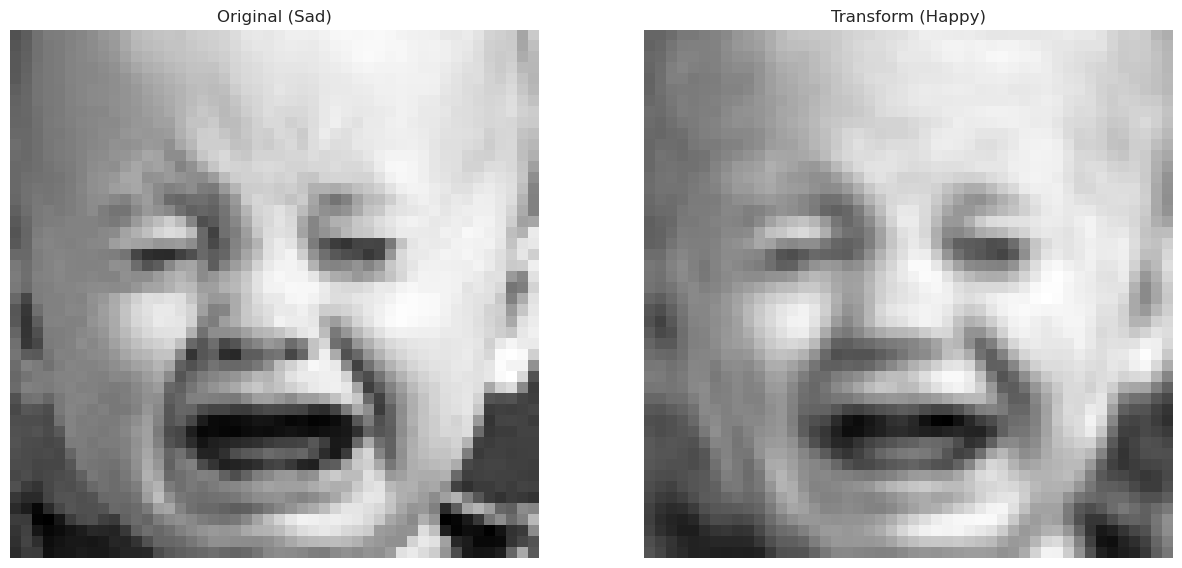

In [181]:
idx_sad = np.random.choice(np.where(y == 0)[0])
sad_original = X[idx_sad].reshape(48, 48)

sad_pca = X_pca[idx_sad]
transition_vector_sad = sad_pca + happy_vector
happy_reconstruct = pca.inverse_transform(transition_vector_sad).reshape(48, 48)

plt.figure(figsize=(15, 10))
plt.subplot(1,2,1)
plt.imshow(sad_original, cmap='gray')
plt.title("Original (Sad)")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(happy_reconstruct, cmap='gray')
plt.title("Transform (Happy)")
plt.axis('off')

plt.show()